# Tensorflow Object Detection API and AWS Sagemaker

In this notebook, you will train and evaluate different models using the [Tensorflow Object Detection API](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/) and [AWS Sagemaker](https://aws.amazon.com/sagemaker/). 

If you ever feel stuck, you can refer to this [tutorial](https://aws.amazon.com/blogs/machine-learning/training-and-deploying-models-using-tensorflow-2-with-the-object-detection-api-on-amazon-sagemaker/).

## Dataset

We are using the [Waymo Open Dataset](https://waymo.com/open/) for this project. The dataset has already been exported using the tfrecords format. The files have been created following the format described [here](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#create-tensorflow-records). You can find data stored on [AWS S3](https://aws.amazon.com/s3/), AWS Object Storage. The images are saved with a resolution of 640x640.

In [1]:
%%capture
%pip install tensorflow_io sagemaker -U

In [2]:
import os
import sagemaker
from sagemaker.estimator import Estimator
from framework import CustomFramework

Save the IAM role in a variable called `role`. This would be useful when training the model.

In [3]:
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::725448147626:role/service-role/AmazonSageMaker-ExecutionRole-20230620T161976
arn:aws:iam::725448147626:role/service-role/AmazonSageMaker-ExecutionRole-20230620T161976


In [4]:
# The train and val paths below are public S3 buckets created by Udacity for this project
inputs = {'train': 's3://object-detection-project-31416/train/', 
        'val': 's3://object-detection-project-31416/val/'} 

# Insert path of a folder in your personal S3 bucket to store tensorboard logs.
tensorboard_s3_prefix = 's3://object-detection-project-31416/logs/'

## Container

To train the model, you will first need to build a [docker](https://www.docker.com/) container with all the dependencies required by the TF Object Detection API. The code below does the following:
* clone the Tensorflow models repository
* get the exporter and training scripts from the the repository
* build the docker image and push it 
* print the container name

In [5]:
#%%bash

# clone the repo and get the scripts
#git clone https://github.com/tensorflow/models.git docker/models

# get model_main and exporter_main files from TF2 Object Detection GitHub repository
#cp docker/models/research/object_detection/exporter_main_v2.py source_dir 
#cp docker/models/research/object_detection/model_main_tf2.py source_dir

In [6]:
# build and push the docker image. This code can be commented after being ran once.
# This will take around 10 mins.
image_name = 'tf2-object-detection'
#!sh ./docker/build_and_push.sh $image_name

To verify that the image was correctly pushed to the [Elastic Container Registry](https://aws.amazon.com/ecr/), you can look at it in the AWS webapp. For example, below you can see that three different images have been pushed to ECR. You should only see one, called `tf2-object-detection`.
![ECR Example](../data/example_ecr.png)


In [7]:
# display the container name
with open (os.path.join('docker', 'ecr_image_fullname.txt'), 'r') as f:
    container = f.readlines()[0][:-1]

print(container)

725448147626.dkr.ecr.us-west-1.amazonaws.com/tf2-object-detection:20230621153530
725448147626.dkr.ecr.us-west-1.amazonaws.com/tf2-object-detection:20230621153530


## Pre-trained model from model zoo

As often, we are not training from scratch and we will be using a pretrained model from the TF Object Detection model zoo. You can find pretrained checkpoints [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). Because your time is limited for this project, we recommend to only experiment with the following models:
* SSD MobileNet V2 FPNLite 640x640	
* SSD ResNet50 V1 FPN 640x640 (RetinaNet50)	
* Faster R-CNN ResNet50 V1 640x640	
* EfficientDet D1 640x640	
* Faster R-CNN ResNet152 V1 640x640	

In the code below, the EfficientDet D1 model is downloaded and extracted. This code should be ajusted if you were to experiment with other architectures.

In [8]:
%%bash
mkdir /tmp/checkpoint
mkdir source_dir/checkpoint_mobilenet
wget -O /tmp/mobilenet.tar.gz http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
tar -zxvf /tmp/mobilenet.tar.gz --strip-components 2 --directory source_dir/checkpoint_mobilenet ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint

--2023-06-23 16:39:37--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
--2023-06-23 16:39:37--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.12.112, 2607:f8b0:4005:802::2010
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.12.112, 2607:f8b0:4005:802::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.12.112|:80... connected.
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.12.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
HTTP request sent, awaiting response... 200 OK
Length: 20518283 (20M) [application/x-tar]
Length: 20518283 (20M) [application/x-tar]
Saving to: ‘/tmp/mobilenet.tar.gz’
Saving to: ‘/tmp/mobilenet.tar.gz’


     0K .......... .......... .......... .......... ..

  2400K .......... .......... .......... .......... .......... 12% 32.2M 1s
  2450K .......... .......... .......... .......... .......... 12%  346M 1s
  2400K .......... .......... .......... .......... .......... 12% 32.2M 1s
  2450K .......... .......... .......... .......... .......... 12%  346M 1s
  2500K .......... .......... .......... .......... .......... 12%  229M 1s
  2550K .......... .......... .......... .......... .......... 12%  198M 1s
  2600K .......... .......... .......... .......... .......... 13% 50.1M 1s
  2650K .......... .......... .......... .......... .......... 13%  360M 1s
  2700K .......... .......... .......... .......... .......... 13%  118M 0s
  2500K .......... .......... .......... .......... .......... 12%  229M 1s
  2550K .......... .......... .......... .......... .......... 12%  198M 1s
  2600K .......... .......... .......... .......... .......... 13% 50.1M 1s
  2650K .......... .......... .......... .......... .......... 13%  360M 1s
  2700K ....

  5200K .......... .......... .......... .......... .......... 26%  264M 0s
  5250K .......... .......... .......... .......... .......... 26%  295M 0s
  5300K .......... .......... .......... .......... .......... 26%  297M 0s
  5350K .......... .......... .......... .......... .......... 26%  388M 0s
  5400K .......... .......... .......... .......... .......... 27% 59.3M 0s
  5000K .......... .......... .......... .......... .......... 25%  171M 0s
  5050K .......... .......... .......... .......... .......... 25%  135M 0s
  5100K .......... .......... .......... .......... .......... 25%  220M 0s
  5150K .......... .......... .......... .......... .......... 25%  235M 0s
  5200K .......... .......... .......... .......... .......... 26%  264M 0s
  5250K .......... .......... .......... .......... .......... 26%  295M 0s
  5300K .......... .......... .......... .......... .......... 26%  297M 0s
  5350K .......... .......... .......... .......... .......... 26%  388M 0s
  5400K ....

  7900K .......... .......... .......... .......... .......... 39%  336M 0s
  7950K .......... .......... .......... .......... .......... 39% 17.3M 0s
  7700K .......... .......... .......... .......... .......... 38% 34.8M 0s
  7750K .......... .......... .......... .......... .......... 38%  375M 0s
  7800K .......... .......... .......... .......... .......... 39%  325M 0s
  7850K .......... .......... .......... .......... .......... 39% 54.6M 0s
  7900K .......... .......... .......... .......... .......... 39%  336M 0s
  7950K .......... .......... .......... .......... .......... 39% 17.3M 0s
  8000K .......... .......... .......... .......... .......... 40%  212M 0s
  8050K .......... .......... .......... .......... .......... 40% 19.6M 0s
  8100K .......... .......... .......... .......... .......... 40%  362M 0s
  8150K .......... .......... .......... .......... .......... 40%  593K 0s
  8200K .......... .......... .......... .......... .......... 41% 3.87M 0s
  8250K ....

 10300K .......... .......... .......... .......... .......... 51%  379M 0s
 10350K .......... .......... .......... .......... .......... 51%  317M 0s
 10400K .......... .......... .......... .......... .......... 52%  316M 0s
 10450K .......... .......... .......... .......... .......... 52%  394M 0s
 10500K .......... .......... .......... .......... .......... 52%  333M 0s
 10550K .......... .......... .......... .......... .......... 52%  372M 0s
 10600K .......... .......... .......... .......... .......... 53%  343M 0s
 10650K .......... .......... .......... .......... .......... 53%  375M 0s
 10700K .......... .......... .......... .......... .......... 53% 41.9M 0s
 10750K .......... .......... .......... .......... .......... 53% 2.47M 0s
 10800K .......... .......... .......... .......... .......... 54%  275M 0s
 10850K .......... .......... .......... .......... .......... 54%  373M 0s
 10900K .......... .......... .......... .......... .......... 54%  391M 0s
 10700K ....

 13200K .......... .......... .......... .......... .......... 66%  350M 0s
 13250K .......... .......... .......... .......... .......... 66%  297M 0s
 13300K .......... .......... .......... .......... .......... 66%  345M 0s
 13350K .......... .......... .......... .......... .......... 66%  386M 0s
 13400K .......... .......... .......... .......... .......... 67%  331M 0s
 13450K .......... .......... .......... .......... .......... 67%  105M 0s
 13500K .......... .......... .......... .......... .......... 67%  341M 0s
 13550K .......... .......... .......... .......... .......... 67%  378M 0s
 13600K .......... .......... .......... .......... .......... 68%  293M 0s
 13650K .......... .......... .......... .......... .......... 68%  365M 0s
 13200K .......... .......... .......... .......... .......... 66%  350M 0s
 13250K .......... .......... .......... .......... .......... 66%  297M 0s
 13300K .......... .......... .......... .......... .......... 66%  345M 0s
 13350K ....

 15850K .......... .......... .......... .......... .......... 79%  234M 0s
 15900K .......... .......... .......... .......... .......... 79%  336M 0s
 15950K .......... .......... .......... .......... .......... 79%  377M 0s
 16000K .......... .......... .......... .......... .......... 80%  316M 0s
 16050K .......... .......... .......... .......... .......... 80%  343M 0s
 16100K .......... .......... .......... .......... .......... 80%  326M 0s
 16150K .......... .......... .......... .......... .......... 80%  359M 0s
 15950K .......... .......... .......... .......... .......... 79%  377M 0s
 16000K .......... .......... .......... .......... .......... 80%  316M 0s
 16050K .......... .......... .......... .......... .......... 80%  343M 0s
 16100K .......... .......... .......... .......... .......... 80%  326M 0s
 16150K .......... .......... .......... .......... .......... 80%  359M 0s
 16200K .......... .......... .......... .......... .......... 81%  275M 0s
 16250K ....

 18750K .......... .......... .......... .......... .......... 93%  382M 0s
 18800K .......... .......... .......... .......... .......... 94%  304M 0s
 18850K .......... .......... .......... .......... .......... 94%  388M 0s
 18900K .......... .......... .......... .......... .......... 94%  391M 0s
 18450K .......... .......... .......... .......... .......... 92%  346M 0s
 18500K .......... .......... .......... .......... .......... 92%  379M 0s
 18550K .......... .......... .......... .......... .......... 92%  375M 0s
 18600K .......... .......... .......... .......... .......... 93%  339M 0s
 18650K .......... .......... .......... .......... .......... 93%  343M 0s
 18700K .......... .......... .......... .......... .......... 93%  368M 0s
 18750K .......... .......... .......... .......... .......... 93%  382M 0s
 18800K .......... .......... .......... .......... .......... 94%  304M 0s
 18850K .......... .......... .......... .......... .......... 94%  388M 0s
 18900K ....

ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0.index


 19950K .......... .......... .......... .......... .......... 99%  392M 0s
 20000K .......... .......... .......... .......              100%  342M=0.4s

2023-06-23 16:39:38 (49.6 MB/s) - ‘/tmp/mobilenet.tar.gz’ saved [20518283/20518283]



ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0.index


## Edit pipeline.config file

The [`pipeline.config`](source_dir/pipeline.config) in the `source_dir` folder should be updated when you experiment with different models. The different config files are available [here](https://github.com/tensorflow/models/tree/master/research/object_detection/configs/tf2).

>Note: The provided `pipeline.config` file works well with the `EfficientDet` model. You would need to modify it when working with other models.

## Launch Training Job

Now that we have a dataset, a docker image and some pretrained model weights, we can launch the training job. To do so, we create a [Sagemaker Framework](https://sagemaker.readthedocs.io/en/stable/frameworks/index.html), where we indicate the container name, name of the config file, number of training steps etc.

The `run_training.sh` script does the following:
* train the model for `num_train_steps` 
* evaluate over the val dataset
* export the model

Different metrics will be displayed during the evaluation phase, including the mean average precision. These metrics can be used to quantify your model performances and compare over the different iterations.

You can also monitor the training progress by navigating to **Training -> Training Jobs** from the Amazon Sagemaker dashboard in the Web UI.

In [11]:
tensorboard_output_config = sagemaker.debugger.TensorBoardOutputConfig(
    s3_output_path=tensorboard_s3_prefix,
    container_local_output_path='/opt/training/'
)

estimator = CustomFramework(
    role=role,
    image_uri=container,
    entry_point='run_training.sh',
    source_dir='source_dir/',
    hyperparameters={
        "model_dir":"/opt/training",        
        "pipeline_config_path": "pipeline-mobilenet.config",
        "num_train_steps": "2000",    
        "sample_1_of_n_eval_examples": "1"
    },
    instance_count=1,
    instance_type='ml.m5.4xlarge',
    tensorboard_output_config=tensorboard_output_config,
    disable_profiler=True,
    base_job_name='tf2-object-detection-default-mobilenet-2'
)

estimator.fit(inputs)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Using provided s3_resource
Using provided s3_resource


INFO:sagemaker:Creating training-job with name: tf2-object-detection-default-mobilenet--2023-06-23-17-07-29-081
INFO:sagemaker:Creating training-job with name: tf2-object-detection-default-mobilenet--2023-06-23-17-07-29-081


2023-06-23 17:07:46 Starting - Starting the training job.2023-06-23 17:07:46 Starting - Starting the training job.....
2023-06-23 17:07:59 Starting - Preparing the instances for training.
2023-06-23 17:07:59 Starting - Preparing the instances for training...........
2023-06-23 17:08:58 Downloading - Downloading input data.
2023-06-23 17:08:58 Downloading - Downloading input data.....
2023-06-23 17:09:18 Training - Downloading the training image.
2023-06-23 17:09:18 Training - Downloading the training image.................
2023-06-23 17:11:04 Training - Training image download completed. Training in progress..
2023-06-23 17:11:04 Training - Training image download completed. Training in progress........2023-06-23 17:11:51,462 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-23 17:11:51,465 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-06-23 17:11:51,479 sagemaker-training-toolkit INFO     No GPUs 

2023-06-23 17:11:51,462 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-23 17:11:51,465 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-06-23 17:11:51,479 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-23 17:11:51,481 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-06-23 17:11:51,496 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-23 17:11:51,498 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-06-23 17:11:51,510 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "train": "/opt/ml/input/data/train",
        "val": "/opt/ml/input/data/val"
    },
    "current_host": "algo-1",
    "current_instance_group": "homogeneousCluster"

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
W0623 17:12:03.632715 139684596750144 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1176: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use `tf.cast` instead.
W0623 17:12:05.773298 139684596750144 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1176: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0623 17:12:08.226706 139684596750144 module_wrapper.py:149] From /usr/local/lib/python3.8/dist-packages/object_detection/builders/optimizer_builder.py:124: The name tf.keras.optimizers.SGD is deprecated

INFO:tensorflow:Step 200 per-step time 2.621s
I0623 17:21:41.386092 139684596750144 model_lib_v2.py:705] Step 200 per-step time 2.621s
INFO:tensorflow:{'Loss/classification_loss': 0.23046306,
 'Loss/localization_loss': 0.35926345,
 'Loss/regularization_loss': 0.15223993,
 'Loss/total_loss': 0.7419665,
 'learning_rate': 0.078460194}
I0623 17:21:41.386360 139684596750144 model_lib_v2.py:708] {'Loss/classification_loss': 0.23046306,
 'Loss/localization_loss': 0.35926345,
 'Loss/regularization_loss': 0.15223993,
 'Loss/total_loss': 0.7419665,
 'learning_rate': 0.078460194}
INFO:tensorflow:Step 200 per-step time 2.621s
I0623 17:21:41.386092 139684596750144 model_lib_v2.py:705] Step 200 per-step time 2.621s
INFO:tensorflow:{'Loss/classification_loss': 0.23046306,
 'Loss/localization_loss': 0.35926345,
 'Loss/regularization_loss': 0.15223993,
 'Loss/total_loss': 0.7419665,
 'learning_rate': 0.078460194}
I0623 17:21:41.386360 139684596750144 model_lib_v2.py:708] {'Loss/classification_loss': 0.

INFO:tensorflow:Step 900 per-step time 2.637s
I0623 17:52:21.707850 139684596750144 model_lib_v2.py:705] Step 900 per-step time 2.637s
INFO:tensorflow:{'Loss/classification_loss': 0.15211844,
 'Loss/localization_loss': 0.18548332,
 'Loss/regularization_loss': 0.150481,
 'Loss/total_loss': 0.48808277,
 'learning_rate': 0.04711991}
I0623 17:52:21.708147 139684596750144 model_lib_v2.py:708] {'Loss/classification_loss': 0.15211844,
 'Loss/localization_loss': 0.18548332,
 'Loss/regularization_loss': 0.150481,
 'Loss/total_loss': 0.48808277,
 'learning_rate': 0.04711991}
INFO:tensorflow:Step 900 per-step time 2.637s
I0623 17:52:21.707850 139684596750144 model_lib_v2.py:705] Step 900 per-step time 2.637s
INFO:tensorflow:{'Loss/classification_loss': 0.15211844,
 'Loss/localization_loss': 0.18548332,
 'Loss/regularization_loss': 0.150481,
 'Loss/total_loss': 0.48808277,
 'learning_rate': 0.04711991}
I0623 17:52:21.708147 139684596750144 model_lib_v2.py:708] {'Loss/classification_loss': 0.152118

INFO:tensorflow:Step 1600 per-step time 2.663s
I0623 18:23:18.535873 139684596750144 model_lib_v2.py:705] Step 1600 per-step time 2.663s
INFO:tensorflow:{'Loss/classification_loss': 0.14599787,
 'Loss/localization_loss': 0.20461765,
 'Loss/regularization_loss': 0.14888065,
 'Loss/total_loss': 0.49949616,
 'learning_rate': 0.007827337}
I0623 18:23:18.536163 139684596750144 model_lib_v2.py:708] {'Loss/classification_loss': 0.14599787,
 'Loss/localization_loss': 0.20461765,
 'Loss/regularization_loss': 0.14888065,
 'Loss/total_loss': 0.49949616,
 'learning_rate': 0.007827337}
INFO:tensorflow:Step 1600 per-step time 2.663s
I0623 18:23:18.535873 139684596750144 model_lib_v2.py:705] Step 1600 per-step time 2.663s
INFO:tensorflow:{'Loss/classification_loss': 0.14599787,
 'Loss/localization_loss': 0.20461765,
 'Loss/regularization_loss': 0.14888065,
 'Loss/total_loss': 0.49949616,
 'learning_rate': 0.007827337}
I0623 18:23:18.536163 139684596750144 model_lib_v2.py:708] {'Loss/classification_lo

INFO:tensorflow:Step 2000 per-step time 2.632s
I0623 18:40:58.864664 139684596750144 model_lib_v2.py:705] Step 2000 per-step time 2.632s
INFO:tensorflow:{'Loss/classification_loss': 0.11490266,
 'Loss/localization_loss': 0.16602413,
 'Loss/regularization_loss': 0.14874923,
 'Loss/total_loss': 0.42967606,
 'learning_rate': 0.0}
I0623 18:40:58.864919 139684596750144 model_lib_v2.py:708] {'Loss/classification_loss': 0.11490266,
 'Loss/localization_loss': 0.16602413,
 'Loss/regularization_loss': 0.14874923,
 'Loss/total_loss': 0.42967606,
 'learning_rate': 0.0}
==EVALUATING THE MODEL==
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 
TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Kera

/usr/local/lib/python3.8/dist-packages/keras/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(
I0623 18:41:17.036549 140387360995136 api.py:459] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
/usr/local/lib/python3.8/dist-packages/keras/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(
I0623 18:41:17.036549 140387360995136 api.py:459] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
I0623 18:41:28.078480 140387360995136 api.py:459] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
Instructions for upda

INFO:tensorflow:Eval metrics at step 2000
I0623 18:42:02.920379 140387360995136 model_lib_v2.py:1015] Eval metrics at step 2000
INFO:tensorflow:#011+ DetectionBoxes_Precision/mAP: 0.132626
I0623 18:42:02.929887 140387360995136 model_lib_v2.py:1018] #011+ DetectionBoxes_Precision/mAP: 0.132626
INFO:tensorflow:#011+ DetectionBoxes_Precision/mAP@.50IOU: 0.278351
I0623 18:42:02.930803 140387360995136 model_lib_v2.py:1018] #011+ DetectionBoxes_Precision/mAP@.50IOU: 0.278351
INFO:tensorflow:#011+ DetectionBoxes_Precision/mAP@.75IOU: 0.109262
I0623 18:42:02.931484 140387360995136 model_lib_v2.py:1018] #011+ DetectionBoxes_Precision/mAP@.75IOU: 0.109262
INFO:tensorflow:#011+ DetectionBoxes_Precision/mAP (small): 0.057406
I0623 18:42:02.932132 140387360995136 model_lib_v2.py:1018] #011+ DetectionBoxes_Precision/mAP (small): 0.057406
INFO:tensorflow:#011+ DetectionBoxes_Precision/mAP (medium): 0.448245
I0623 18:42:02.932761 140387360995136 model_lib_v2.py:1018] #011+ DetectionBoxes_Precision/mAP

I0623 18:46:29.185111 140474901313344 api.py:459] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
I0623 18:46:29.185111 140474901313344 api.py:459] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
I0623 18:46:37.404948 140474901313344 api.py:459] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
I0623 18:46:40.793632 140474901313344 api.py:459] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
I0623 18:46:37.404948 140474901313344 api.py:459] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
I0623 18:46:40.793632 140474901313344 api.py:459] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
W0623 18:46:42.851813 140474901313344 save_impl.py:66] Skipping full serialization of Keras layer <object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch object at 0x7fc22c18fa60>, because it is not built.
W0623 18:46:43.081368 140474901313344

W0623 18:46:42.851813 140474901313344 save_impl.py:66] Skipping full serialization of Keras layer <object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch object at 0x7fc22c18fa60>, because it is not built.
W0623 18:46:43.081368 140474901313344 save_impl.py:66] Skipping full serialization of Keras layer <keras.layers.convolutional.separable_conv2d.SeparableConv2D object at 0x7fc1e82f2850>, because it is not built.
W0623 18:46:43.081549 140474901313344 save_impl.py:66] Skipping full serialization of Keras layer <object_detection.core.freezable_batch_norm.FreezableBatchNorm object at 0x7fc1e82a2fd0>, because it is not built.
W0623 18:46:43.081616 140474901313344 save_impl.py:66] Skipping full serialization of Keras layer <keras.layers.core.lambda_layer.Lambda object at 0x7fc1e82a28e0>, because it is not built.
W0623 18:46:43.081674 140474901313344 save_impl.py:66] Skipping full serialization of Keras layer <keras.layers.convolutional.separable_conv2d.SeparableConv2D object at 0x7fc

W0623 18:46:58.418571 140474901313344 save.py:274] Found untraced functions such as WeightSharedConvolutionalBoxPredictor_layer_call_fn, WeightSharedConvolutionalBoxPredictor_layer_call_and_return_conditional_losses, WeightSharedConvolutionalBoxHead_layer_call_fn, WeightSharedConvolutionalBoxHead_layer_call_and_return_conditional_losses, WeightSharedConvolutionalClassHead_layer_call_fn while saving (showing 5 of 173). These functions will not be directly callable after loading.
W0623 18:46:58.418571 140474901313344 save.py:274] Found untraced functions such as WeightSharedConvolutionalBoxPredictor_layer_call_fn, WeightSharedConvolutionalBoxPredictor_layer_call_and_return_conditional_losses, WeightSharedConvolutionalBoxHead_layer_call_fn, WeightSharedConvolutionalBoxHead_layer_call_and_return_conditional_losses, WeightSharedConvolutionalClassHead_layer_call_fn while saving (showing 5 of 173). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to:

You should be able to see your model training in the AWS webapp as shown below:
![ECR Example](../data/example_trainings.png)


## Improve on the intial model

Most likely, this initial experiment did not yield optimal results. However, you can make multiple changes to the `pipeline.config` file to improve this model. One obvious change consists in improving the data augmentation strategy. The [`preprocessor.proto`](https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto) file contains the different data augmentation method available in the Tf Object Detection API. Justify your choices of augmentations in the writeup.

Keep in mind that the following are also available:
* experiment with the optimizer: type of optimizer, learning rate, scheduler etc
* experiment with the architecture. The Tf Object Detection API model zoo offers many architectures. Keep in mind that the pipeline.config file is unique for each architecture and you will have to edit it.
* visualize results on the test frames using the `2_deploy_model` notebook available in this repository.

In the cell below, write down all the different approaches you have experimented with, why you have chosen them and what you would have done if you had more time and resources. Justify your choices using the tensorboard visualizations (take screenshots and insert them in your writeup), the metrics on the evaluation set and the generated animation you have created with [this tool](../2_run_inference/2_deploy_model.ipynb).

In [ ]:
# your writeup goes here.

(This text is included in all notebooks)

<h3>Warming up</h3><br>
To get acquainted with the project and the SageMaker framework, I tried to run the notebook as provided, but got an error related to the type of instance type requested. After searching the forums for help, I found a solution for this problem, and tried, as suggested, with an instance type of 'ml.m5.4xlarge' and 200 training steps.

The error no longer ocurred, but I got horrible results. No boxes at all were output in predictions, as seen here:

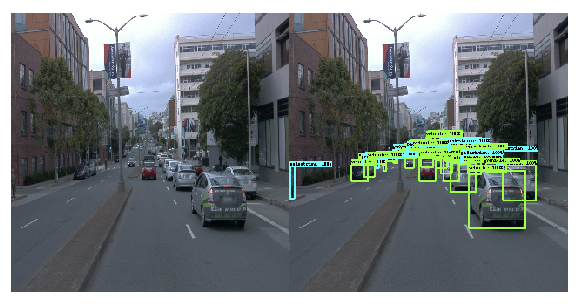


To make sure the training pipeline was setup properly, I decided to greatly restrict the training dataset to just one .tfrecord file (20 images). If everything was ok, the model should overfit quickly to this reduced dataset, and it did. So my conclusion was that 200 training steps (which is, using a batch size of 8, not even an entire epoch over the training set) was utterly insufficient. I decided to crank up to 2000 training steps. Finally, boxes started to be predicted, and that was a sign of being on the right track.

<h3>Improving on the initial model</h3><br>
    The first idea that came into my mind was to improve the dataset augmentation by adding more random transformations. Nevertheless, I found out that maintaining the same 2000 steps of training, the loss was actually greater than before, although the model seemed to be overfitting less:

Training loss with augmentations (less overfitting, but worse results after 2000 steps):
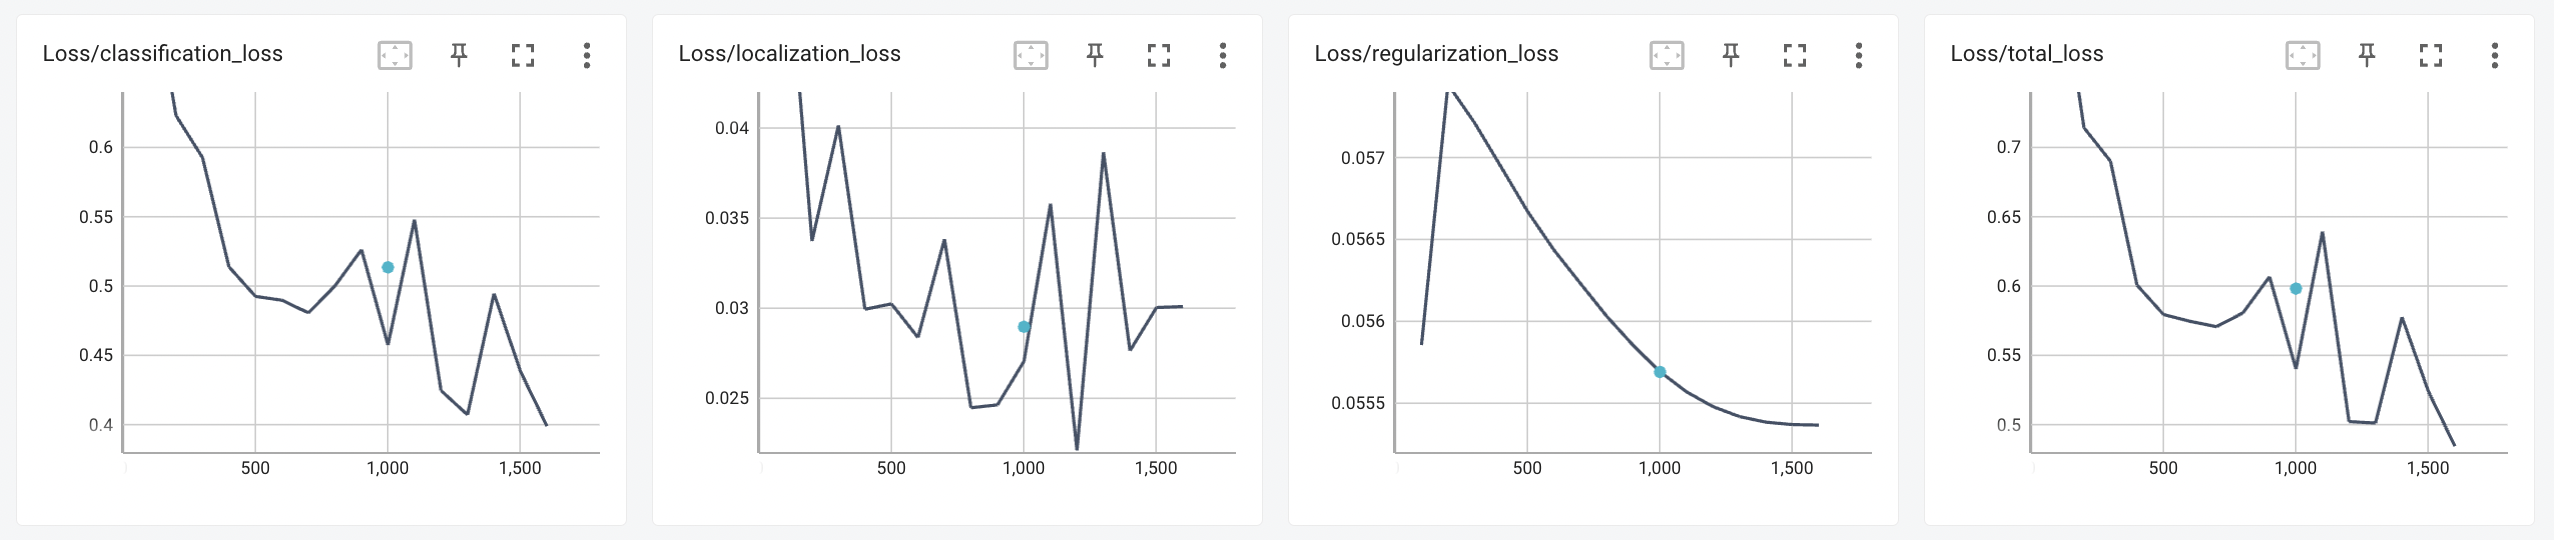

My take on this is that adding this variability to the dataset will actually improve performance on the test set, but at the expense of requiring longer train times. Given the constraints on time and resources, I decided to actually simplify the augmentations and leave only the random horizontal flip, and tune the <b>learning rate cosine decay</b> parameters to better fit the 2000 steps. Even though the gap between train and test loss was greater (sign of overfitting), with that I got reasonable performance.

Training loss with less augmentations and tuned decay cosine rate (more overfitting but better results @2000 steps):
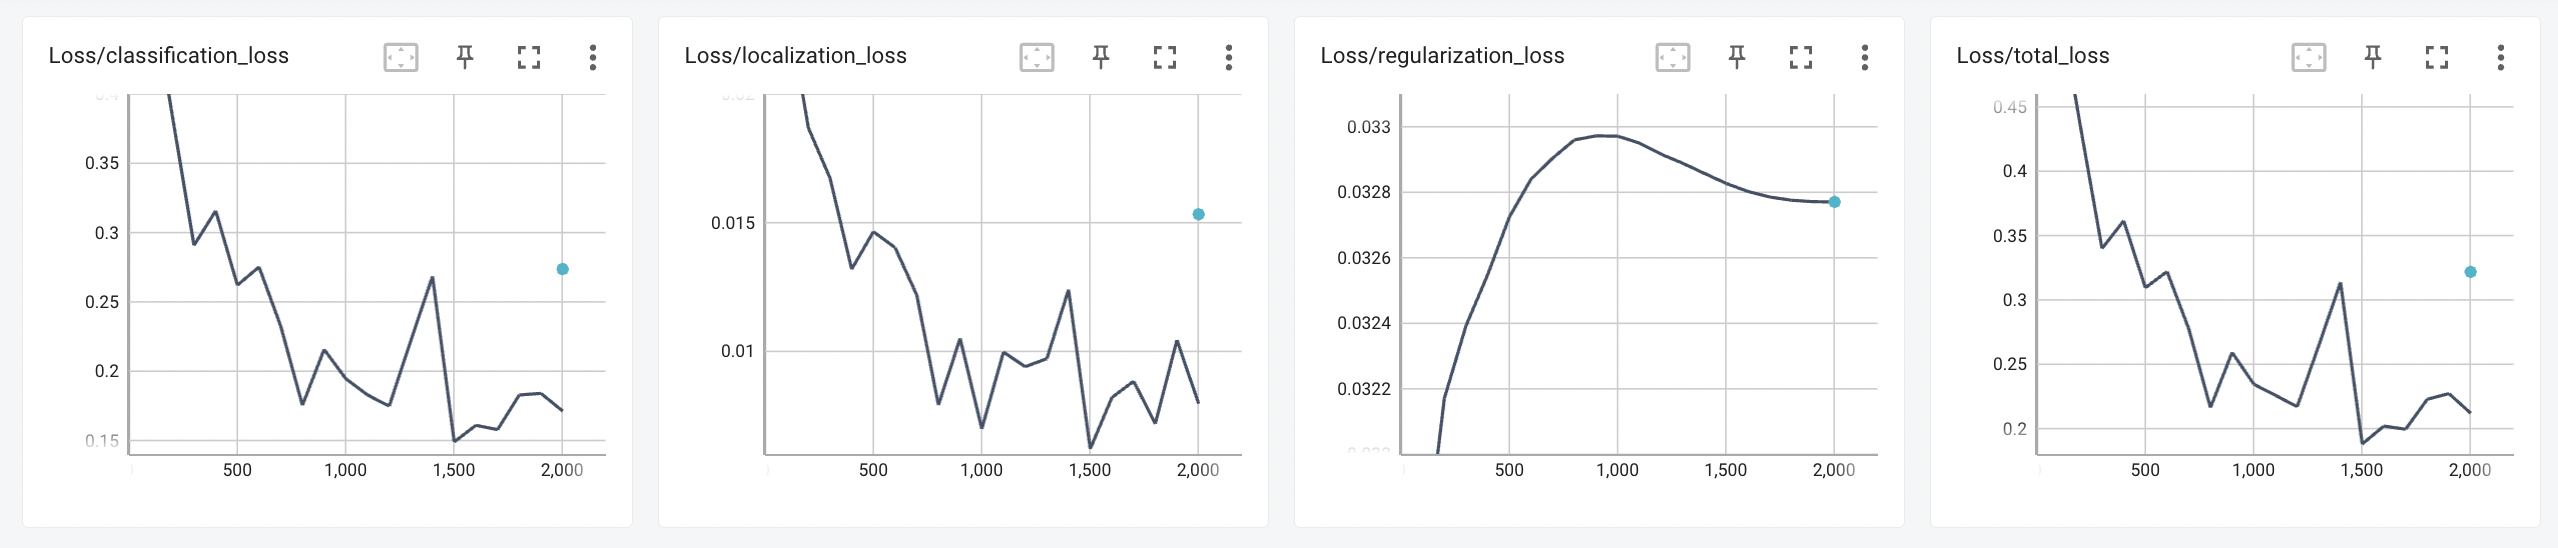

<h3>Further improvements</h3><br>
    
Given sufficient time and resources (each training run took ~2h -even a minimum training run with very little data took a minimum of 20 minutes- so time and associated economic cost was a very great constraint here), there is a huge hyperparameter surface to explore, including different augmentation schemes. A few things that would be worth trying tweaking: <br><br>

<lu>
    <li>Optimizer (Adam, SGD, RMSProp...)</li>
    <li>Learning rate schedule</li>
    <li>Regularization</li>
    <li>Batch normalization parameters</li>
    <li>Aspect ratios of anchors</li>
    <li>Non max suppressor parameters</li>
    <li>Augmentations</li>
    <li>...</li>
</lu>
    
<h3>Testing other models</h3><br>    
    
After downloading the pretrained models and corresponding pipeline.config files, I chose the <b>SSD MobileNet V2 FPNLite 640x640</b> (a smaller model), and the <b>Faster R-CNN ResNet152 V1 640x640</b> (a bigger model). The train times differed greatly, getting the following results on the test set:

Tuned EfficientDet:
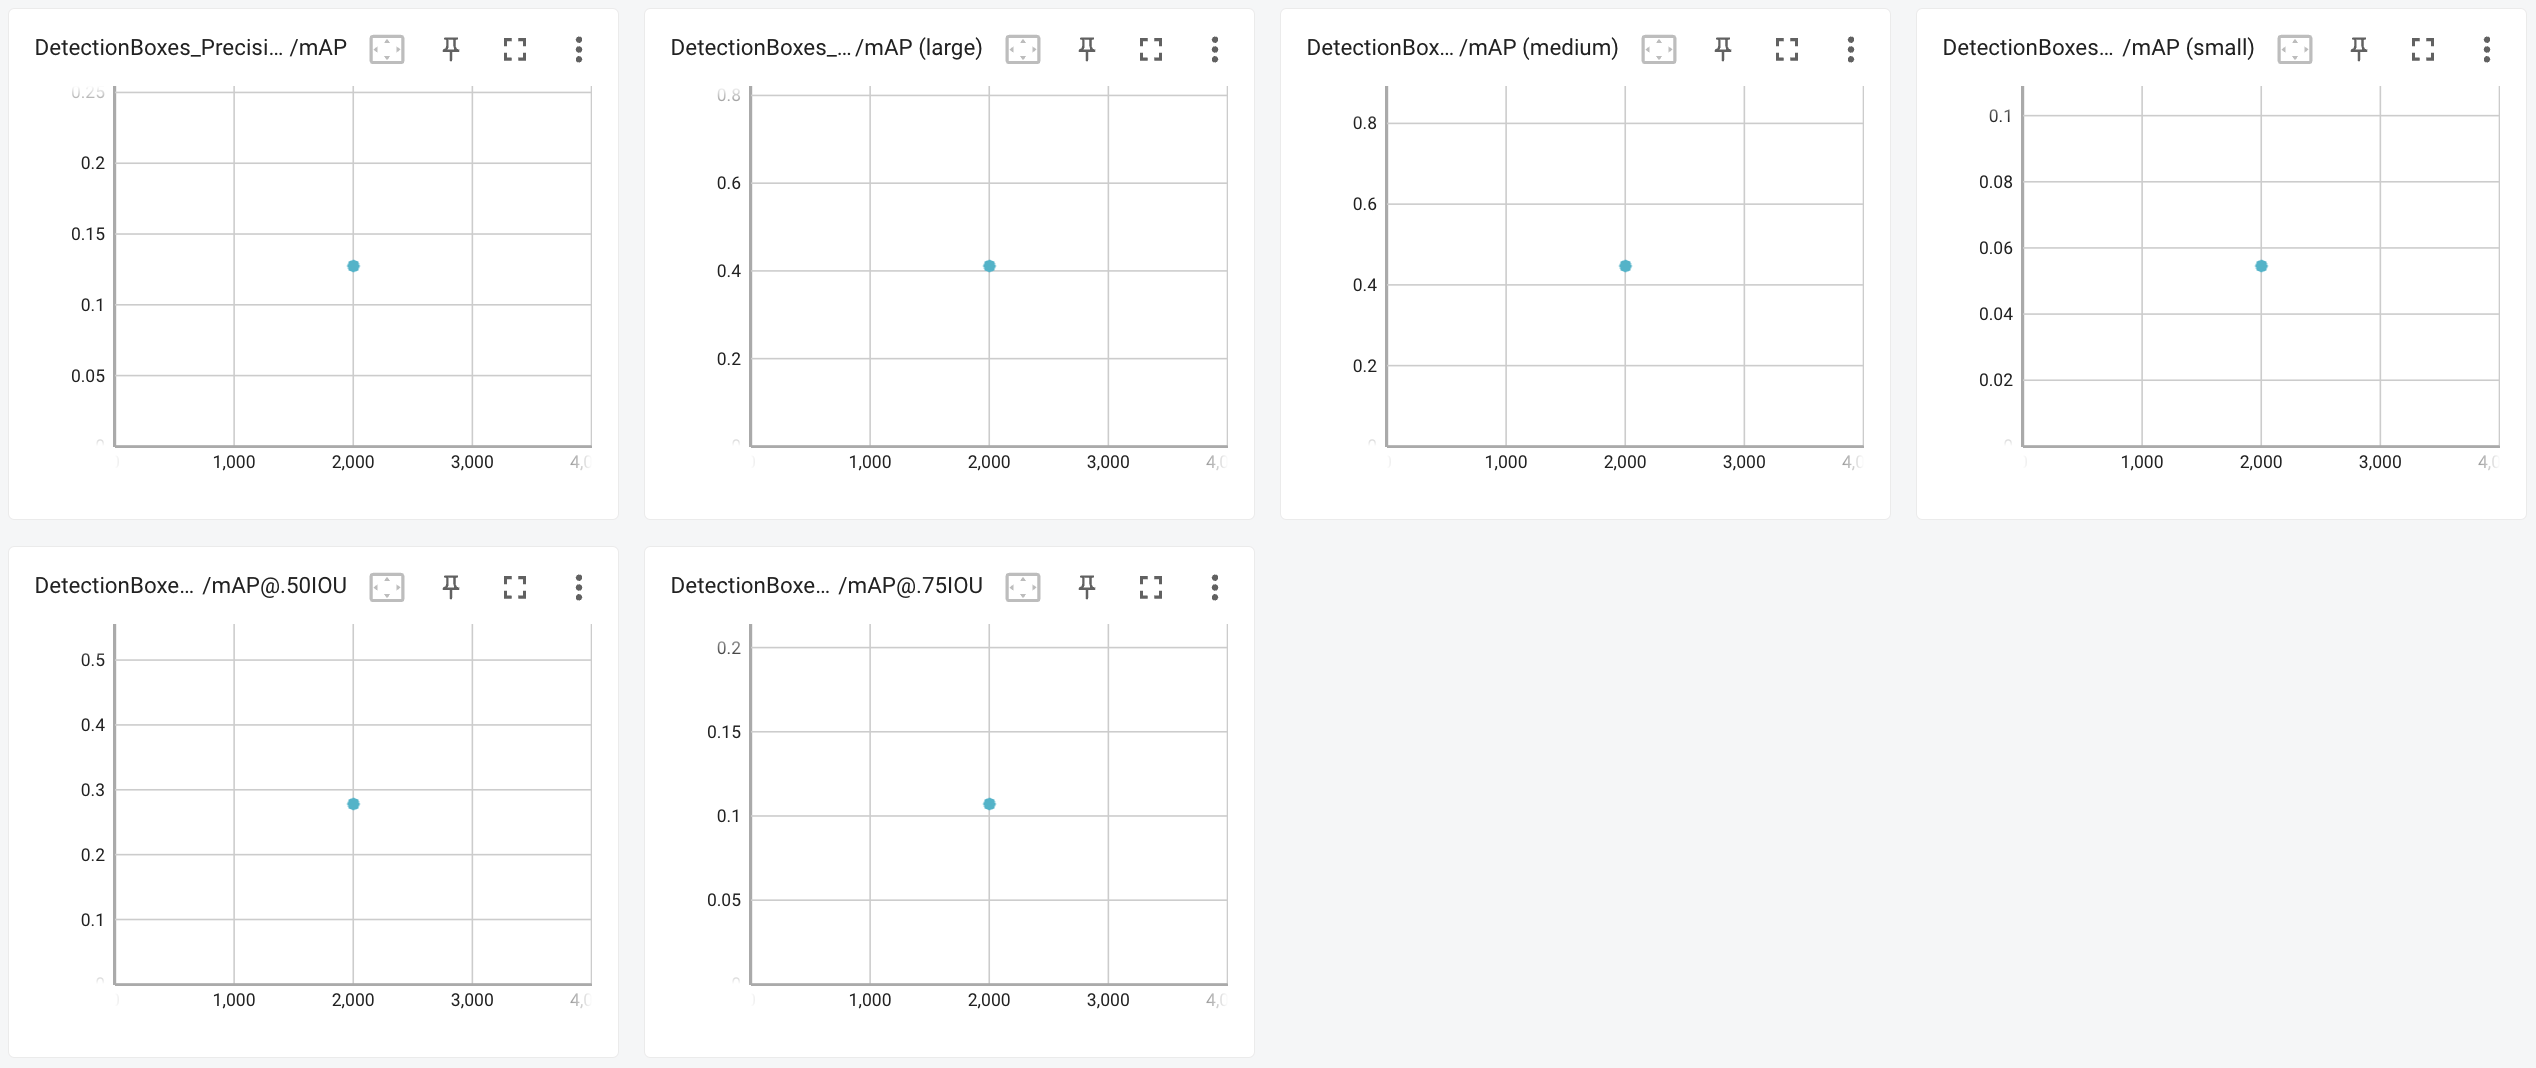

mAP@.50 = 0.2778, mAP@.75 = 0.107, avg = 0.1924

MobileNet:
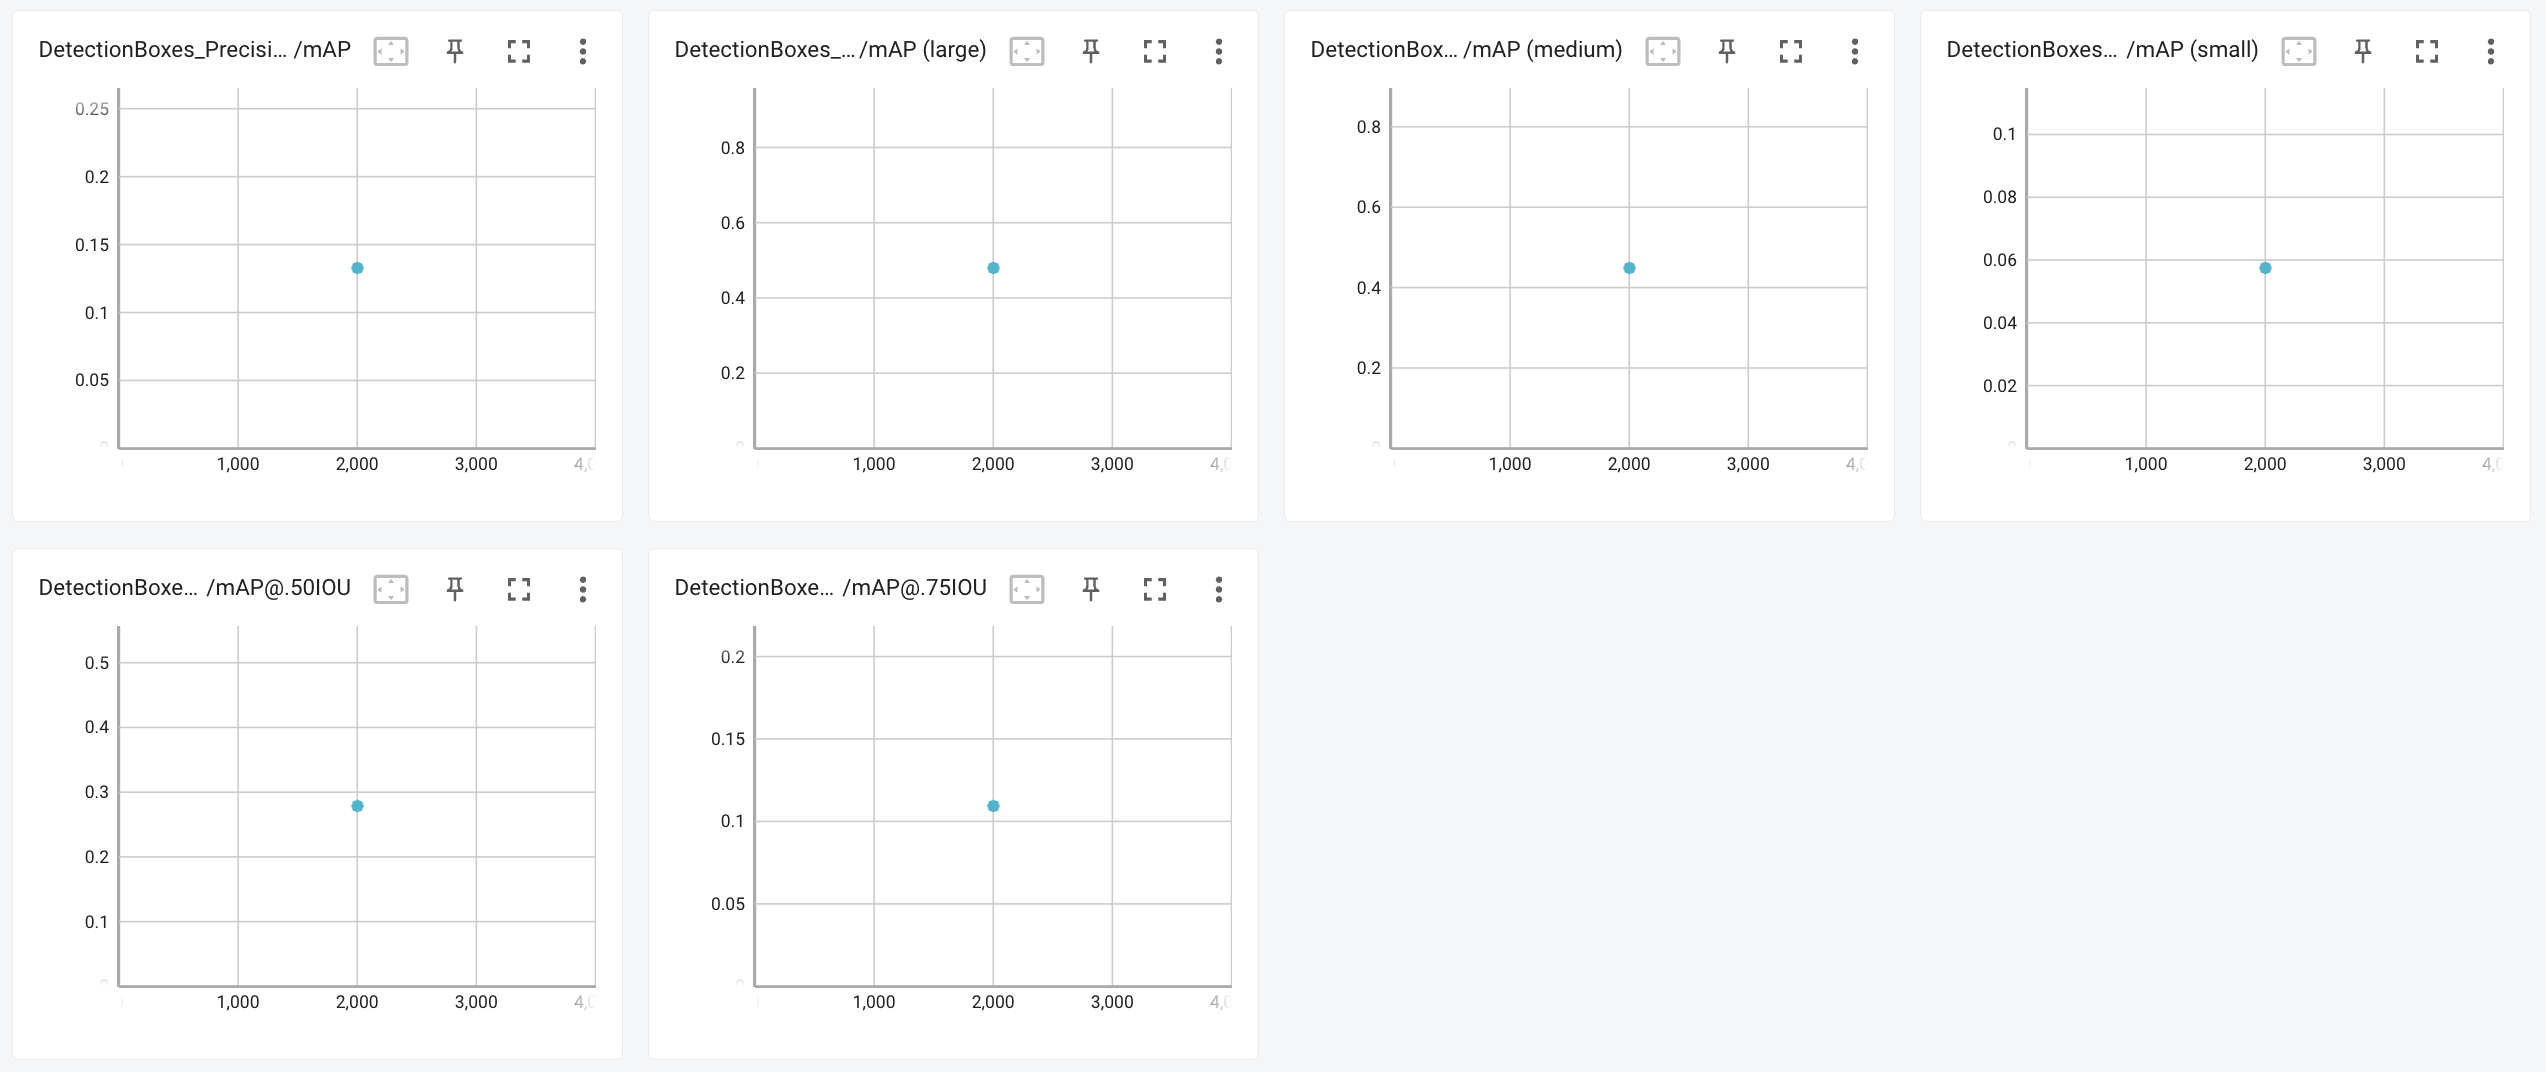

mAP@.50 = 0.2784, mAP@.75 = 0.1093, avg = 0.19385

FasterRCNN:
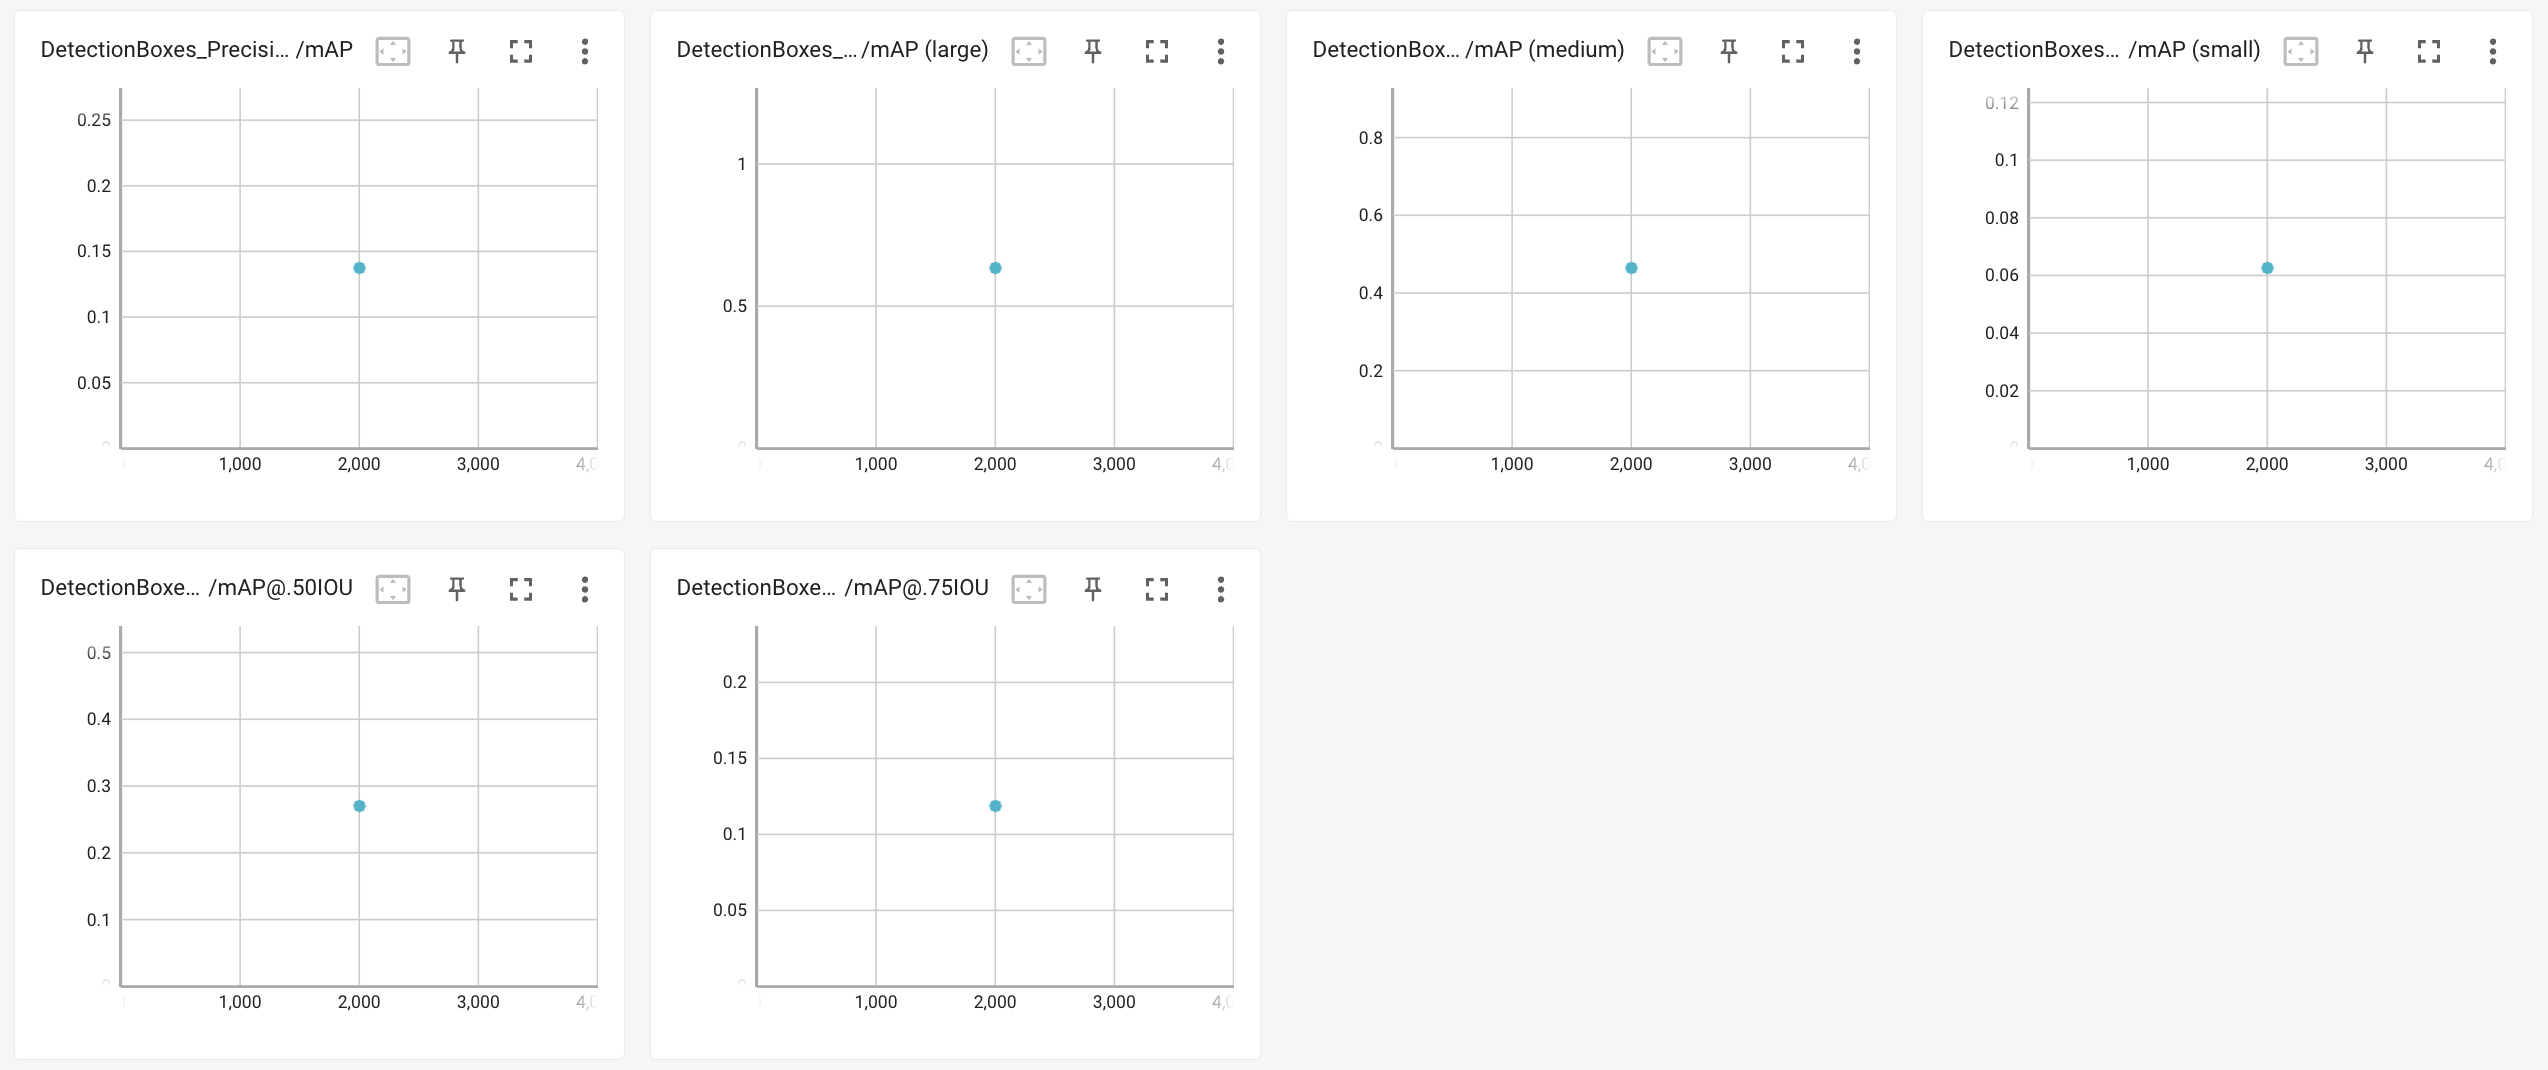

mAP@.50 = 0.2699, mAP@.75 = 0.1186, avg = 0.19425

So performances are very similar, but FasterRCNN does slightly better on the average of mAP@.5 and mAP@.75. I'm going to use FasterRCNN. It is worth noting that, while performance is better, it is important to consider other factors, as training time, model size a inference time. Should these be taken into account, FasterRCNN might not be the best option (the model took ~11h to train, and it's ~10X bigger than the MobileNet model). That said, I'm going to proceed to part II and generate the prediction video with this model.